# TBATS



## Install libraries

In [1]:
import pandas as pd

## Данные

В этом примере мы будем использовать один временной ряд из набора данных [M5 Competition. Этот ряд представляет собой ежедневные продажи продукта в магазине Walmart. Комбинация «продукт-магазин», которую мы будем использовать в этом блокноте, имеет `unique_id = FOODS_3_586_CA_3`.

Мы загрузим следующие фреймы данных:

- `Y_ts`: (pandas DataFrame) Целевой временной ряд со столбцами [`unique_id`, `ds`, `y`].
- `X_ts`: (pandas DataFrame) Экзогенный временной ряд со столбцами [`unique_id`, `ds`, экзогенные регрессоры].

In [2]:
base_url = 'https://datasets-nixtla.s3.amazonaws.com'
filters = [('unique_id', '=', 'FOODS_3_586_CA_3')]
Y_ts = pd.read_parquet(f'{base_url}/m5_y.parquet', filters=filters)
X_ts = pd.read_parquet(f'{base_url}/m5_x.parquet', filters=filters)

Мы можем построить график продаж этой комбинации «товар-магазин» с помощью метода `statsforecast.plot` из класса [StatsForecast](https://nixtla.github.io/statsforecast/core.html#statsforecast). Этот метод имеет несколько параметров, и ниже приведены параметры, необходимые для построения графиков в этом блокноте.

- `df`: Фрейм данных pandas со столбцами [`unique_id`, `ds`, `y`].
- `forecasts_df`: Фрейм данных pandas со столбцами [`unique_id`, `ds`] и моделями.
- `engine`: str = `matplotlib`. Это также может быть `plotly`. `plotly` генерирует интерактивные графики, а `matplotlib` генерирует статические графики.

In [4]:
pip install StatsForecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 10.2 MB/s eta 0:00:00


In [5]:
from statsforecast import StatsForecast

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


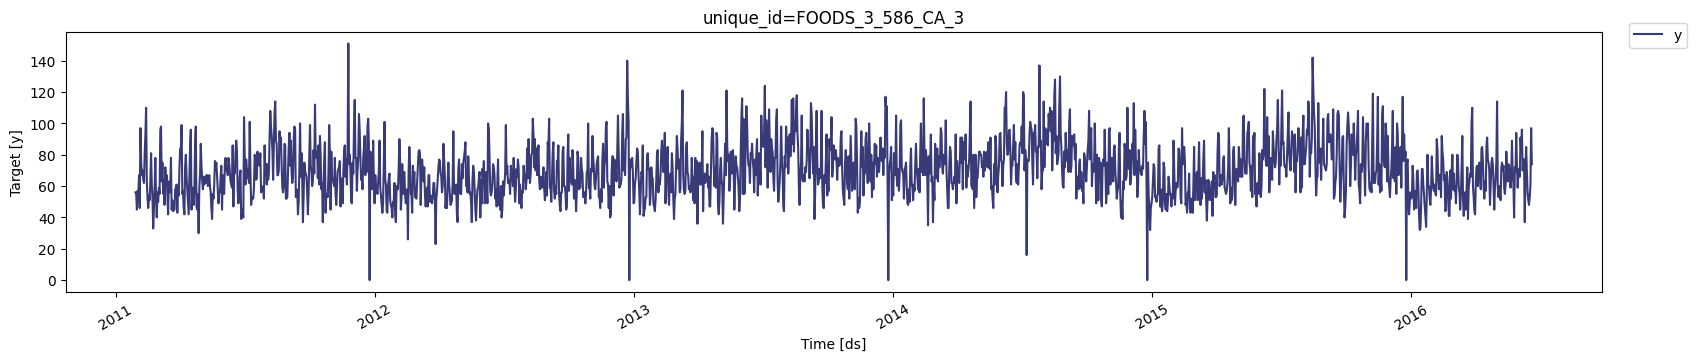

In [6]:
StatsForecast.plot(Y_ts)

В M5 Competition было включено несколько экзогенных регрессоров. Здесь мы будем использовать следующие два.  
    
- `sell_price`: цена продукта для данного магазина. Цена предоставляется за неделю.
- `snap_CA`: Бинарная переменная, указывающая, разрешает ли магазин покупки по SNAP (1 - если да, 0 - в противном случае). SNAP расшифровывается как Supplement Nutrition Assitance Program, и эта программа предоставляет людям и семьям деньги, чтобы помочь им приобрести продукты питания.

In [7]:
X_ts = X_ts[['unique_id', 'ds', 'sell_price', 'snap_CA']]
X_ts.head()

,unique_id,ds,sell_price,snap_CA
0,FOODS_3_586_CA_3,2011-01-29,1.48,0
1,FOODS_3_586_CA_3,2011-01-30,1.48,0
2,FOODS_3_586_CA_3,2011-01-31,1.48,0
3,FOODS_3_586_CA_3,2011-02-01,1.48,1
4,FOODS_3_586_CA_3,2011-02-02,1.48,1


Здесь `unique_id` - это категория, но для экзогенных регрессоров это должна быть строка.

In [8]:
X_ts['unique_id'] = X_ts.unique_id.astype(str)

Мы можем построить график экзогенных регрессоров с помощью `plotly`. Мы могли бы использовать `statsforecast.plot`, но тогда один из регрессоров должен быть переименован в `y`, а перед построением прогноза его имя должно быть изменено на первоначальное.

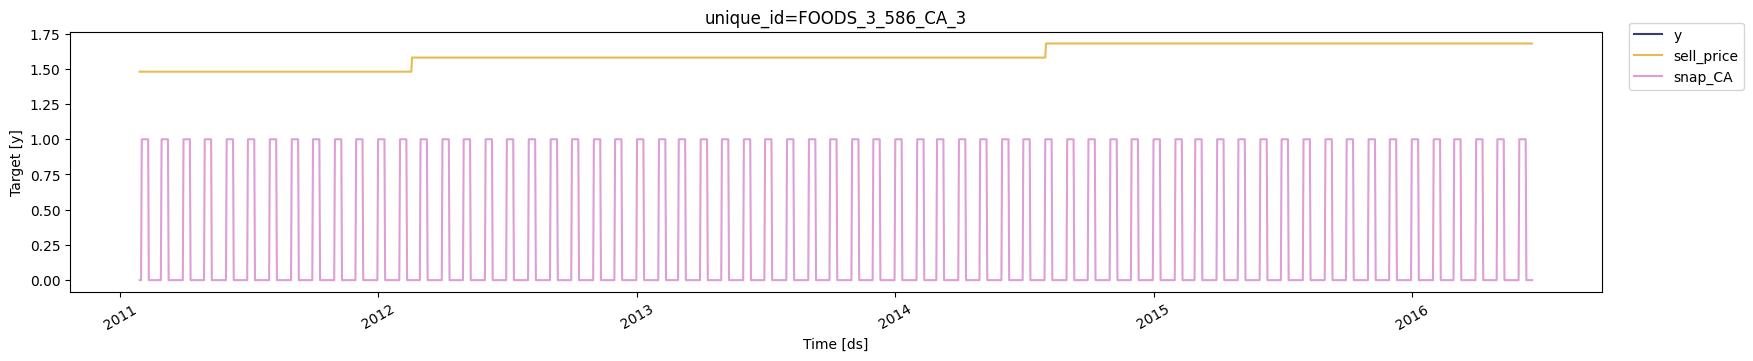

In [9]:
StatsForecast.plot(Y_ts, X_ts, max_insample_length=0)

Из этого графика можно сделать вывод, что цена увеличивалась дважды и что SNAP происходит через регулярные промежутки времени.

## Split train/test set

В конкурсе M5 участники должны были спрогнозировать продажи за последние 28 дней в наборе данных. Мы будем использовать тот же горизонт прогнозирования и создадим обучающий и тестовый наборы соответственно.

In [10]:
# Extract dates for train and test set
dates = Y_ts['ds'].unique()
dtrain = dates[:-28]
dtest = dates[-28:]

Y_train = Y_ts.query('ds in @dtrain')
Y_test = Y_ts.query('ds in @dtest')

X_train = X_ts.query('ds in @dtrain')
X_test = X_ts.query('ds in @dtest')

Экзогенные регрессоры должны располагаться после целевой переменной `y`.

In [11]:
train = Y_train.merge(X_ts, how = 'left', on = ['unique_id', 'ds'])
train.head()

,unique_id,ds,y,sell_price,snap_CA
0,FOODS_3_586_CA_3,2011-01-29,56.0,1.48,0
1,FOODS_3_586_CA_3,2011-01-30,55.0,1.48,0
2,FOODS_3_586_CA_3,2011-01-31,45.0,1.48,0
3,FOODS_3_586_CA_3,2011-02-01,57.0,1.48,1
4,FOODS_3_586_CA_3,2011-02-02,54.0,1.48,1


## Создание будущих экзогенных регрессоров

Нам нужно включить будущие значения экзогенных регрессоров, чтобы мы могли строить прогнозы. Обратите внимание, что у нас уже есть эта информация в `X_test`.

In [12]:
X_test.head()

,unique_id,ds,sell_price,snap_CA
1941,FOODS_3_586_CA_3,2016-05-23,1.68,0
1942,FOODS_3_586_CA_3,2016-05-24,1.68,0
1943,FOODS_3_586_CA_3,2016-05-25,1.68,0
1944,FOODS_3_586_CA_3,2016-05-26,1.68,0
1945,FOODS_3_586_CA_3,2016-05-27,1.68,0


Если будущие значения экзогенных регрессоров недоступны, то их необходимо спрогнозировать или исключить регрессоры из модели. Без них невозможно построить прогноз.



## Train model

Для построения прогноза мы будем использовать модель AutoTBATS, которая является одной из моделей, доступных в StatsForecast. Чтобы использовать эту модель, нам сначала нужно импортировать ее из `statsforecast.models`, а затем инсталлировать ее. Учитывая, что мы работаем с ежедневными данными, нам нужно установить `season_length = [7, 365]`.

In [13]:
from statsforecast.models import AutoTBATS

In [15]:
# Create a list with the model and its instantiation parameters

models = [AutoTBATS(season_length=[7, 365])]

Далее нам нужно создать новый объект StatsForecast, который имеет следующие параметры.

- `df`: Кадр данных с обучающими данными.
- `models`: Список моделей, определенных на предыдущем шаге.
- `freq`: Строка, указывающая частоту данных.
- `n_jobs`: Целое число, указывающее количество ядер, используемых при параллельной обработке. Используйте -1, чтобы выбрать все ядра.

In [16]:
sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=1,
)

Теперь мы готовы сгенерировать прогноз. Для этого мы воспользуемся методом `forecast`, который принимает следующие аргументы.

- `h`: целое число, обозначающее горизонт прогноза. В данном случае мы будем прогнозировать на ближайшие 28 дней.
- `X_df`: фрейм данных pandas с будущими значениями экзогенных регрессоров.
- `level`:  список значений с доверительными уровнями интервалов прогнозирования. Например, `level=[95]` означает, что диапазон значений должен включать фактическое будущее значение с вероятностью 95%.

In [17]:
horizon = 28
level = [95]

fcst = sf.forecast(df=train, h=horizon, X_df=X_test, level=level)
fcst.head()

/usr/local/lib/python3.11/dist-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


,unique_id,ds,AutoTBATS,AutoTBATS-lo-95,AutoTBATS-hi-95
0,FOODS_3_586_CA_3,2016-05-23,66.521950,40.697506,92.346390
1,FOODS_3_586_CA_3,2016-05-24,62.211231,35.637897,88.784561
2,FOODS_3_586_CA_3,2016-05-25,59.627083,32.825230,86.428932
3,FOODS_3_586_CA_3,2016-05-26,62.950195,36.078079,89.822311
4,FOODS_3_586_CA_3,2016-05-27,66.876770,39.969059,93.784485


Для одного временного ряда вычисления заняли 32 секунды.

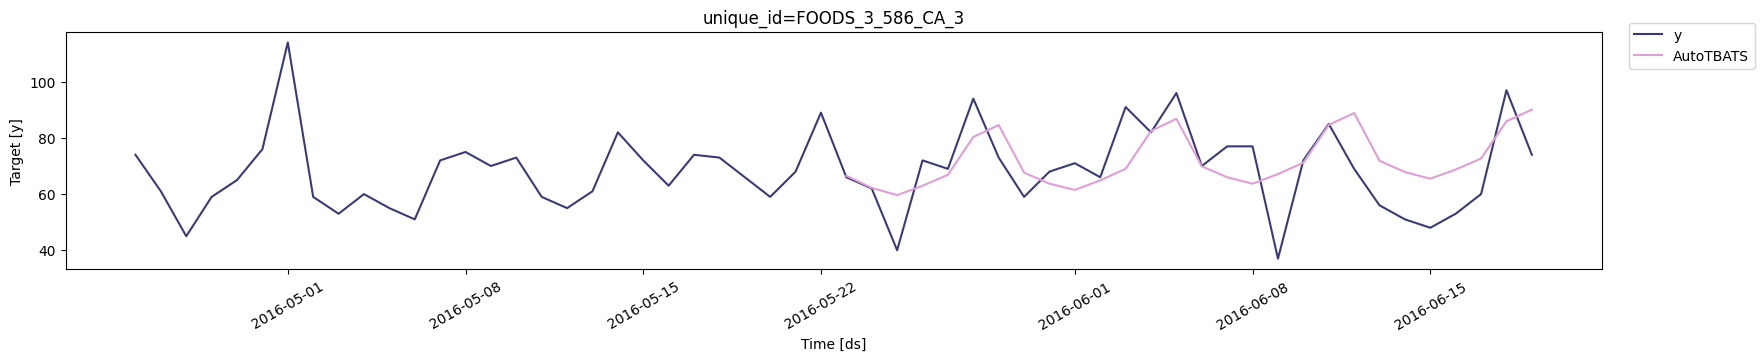

In [18]:
StatsForecast.plot(Y_ts, fcst, max_insample_length=28*2)

## Оценка качества

Мы объединим тестовый набор и прогноз, чтобы оценить точность с помощью средней абсолютной ошибки (MAE).

In [19]:
res = Y_test.merge(fcst, how='left', on=['unique_id', 'ds'])
res.head()

,unique_id,ds,y,AutoTBATS,AutoTBATS-lo-95,AutoTBATS-hi-95
0,FOODS_3_586_CA_3,2016-05-23,66.0,66.521950,40.697506,92.346390
1,FOODS_3_586_CA_3,2016-05-24,62.0,62.211231,35.637897,88.784561
2,FOODS_3_586_CA_3,2016-05-25,40.0,59.627083,32.825230,86.428932
3,FOODS_3_586_CA_3,2016-05-26,72.0,62.950195,36.078079,89.822311
4,FOODS_3_586_CA_3,2016-05-27,69.0,66.876770,39.969059,93.784485


In [21]:
mae = abs(res['y']-res['AutoTBATS']).mean()
print('The MAE with exogenous regressors is '+str(round(mae,2)))

The MAE with exogenous regressors is 10.48


Чтобы проверить, были ли полезны экзогенные регрессоры или нет, нам нужно снова сгенерировать прогноз, теперь уже без них. Для этого мы просто передаем кадр данных без экзогенных переменных в метод `forecast`. Обратите внимание, что данные включают только `unique_id`, `ds` и `y`. Метод `forecast` больше не требует будущих значений экзогенных регрессоров `X_df`.

In [22]:
# univariate model
fcst_u = sf.forecast(df=train[['unique_id', 'ds', 'y']], h=28)

res_u = Y_test.merge(fcst_u, how='left', on=['unique_id', 'ds'])
mae_u = abs(res_u['y']-res_u['AutoTBATS']).mean()

/usr/local/lib/python3.11/dist-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(


Без учета дополнительных переменных вычисления занимают 12 секунд, но точность MAE не изменилась.

In [24]:
print('The MAE without exogenous regressors is '+str(round(mae_u,2)))

The MAE without exogenous regressors is 10.48


TBATS фокусируется на автономном прогнозировании, используя только исторические значения целевого ряда и его компоненты (тренд, сезонность, ARMA-ошибки).

Реализации TBATS не позволяют явно добавлять внешние переменные, в отличие от моделей типа ARIMAX, Prophet или регрессии с ARMA-ошибками. Мы млжем формально оставить эти переменные в наборе данных, но они никак не влияют на тосность прогнозирования.

**Обходные пути**

Если вам критично учесть дополнительные переменные, можно рассмотреть следующие подходы:

a) Предварительная обработка данных

Постройте регрессионную модель с экзогенными переменными, а затем примените TBATS к остаткам.

b) Гибридные модели

Используйте предсказания TBATS как один из признаков в модели, которая включает экзогенные переменные (например, gradient boosting или нейросети).

c) Расширение функционала

Напишите кастомную модель, комбинирующую логику TBATS с регрессионными компонентами. Также регрессоры можно добавить в модель ARMA примоделировании остатков, взяв вместо нее модель ARIMAX.

## AutoArima

Для сравнения посмотрим как для этих данных работает модель ARIMA.

In [25]:
from statsforecast.models import AutoARIMA

In [26]:
models = [AutoARIMA(season_length=7)]

In [27]:
sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=1,
)

In [28]:
horizon = 28
level = [95]

fcst = sf.forecast(df=train, h=horizon, X_df=X_test, level=level)
fcst.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,FOODS_3_586_CA_3,2016-05-23,73.616867,44.999283,102.234459
1,FOODS_3_586_CA_3,2016-05-24,72.559868,42.355267,102.764473
2,FOODS_3_586_CA_3,2016-05-25,69.309807,38.824066,99.795540
3,FOODS_3_586_CA_3,2016-05-26,64.670769,34.157162,95.184372
4,FOODS_3_586_CA_3,2016-05-27,63.950855,33.437233,94.464478


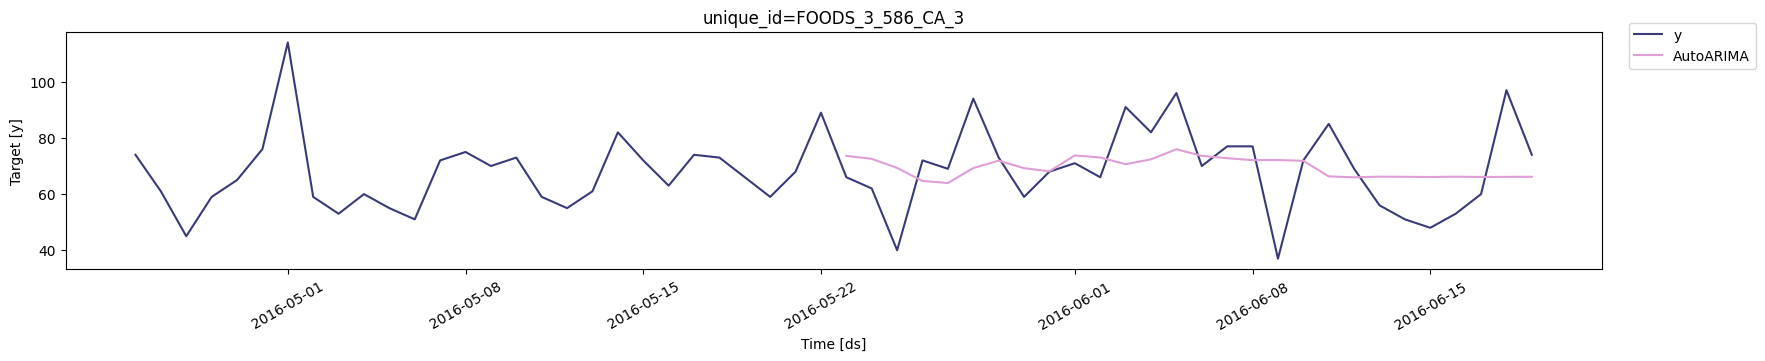

In [29]:
StatsForecast.plot(Y_ts, fcst, max_insample_length=28*2)

In [30]:
res = Y_test.merge(fcst, how='left', on=['unique_id', 'ds'])
res.head()

,unique_id,ds,y,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,FOODS_3_586_CA_3,2016-05-23,66.0,73.616867,44.999283,102.234459
1,FOODS_3_586_CA_3,2016-05-24,62.0,72.559868,42.355267,102.764473
2,FOODS_3_586_CA_3,2016-05-25,40.0,69.309807,38.824066,99.795540
3,FOODS_3_586_CA_3,2016-05-26,72.0,64.670769,34.157162,95.184372
4,FOODS_3_586_CA_3,2016-05-27,69.0,63.950855,33.437233,94.464478


In [31]:
mae = abs(res['y']-res['AutoARIMA']).mean()
print('The MAE with exogenous regressors is '+str(round(mae,2)))

The MAE with exogenous regressors is 11.68


In [32]:
# univariate model
fcst_u = sf.forecast(df=train[['unique_id', 'ds', 'y']], h=28)

res_u = Y_test.merge(fcst_u, how='left', on=['unique_id', 'ds'])
mae_u = abs(res_u['y']-res_u['AutoARIMA']).mean()

In [33]:
print('The MAE without exogenous regressors is '+str(round(mae_u,2)))

The MAE without exogenous regressors is 12.18


Точность 11.68 хуже, чем у TBATS (10.48), время больше, практически 2 минуты. Однако, дополнительные переменные могут быть учтены напрямую и позволяют повысить точность на 4%.